In [2]:
import h5py
import pandas as pd
import numpy as np
import os


def parse_timestamp(ts):
    ts = str(ts)
    if len(ts) == 17:
        year = int(ts[0:4])
        month = int(ts[4:6])
        day = int(ts[6:8])
        hour = int(ts[8:10])
        minute = int(ts[10:12])
        second = int(ts[12:14])
        millisecond = int(ts[14:17])
        microsecond = millisecond * 1000

        return pd.Timestamp(year, month, day, hour, minute, second, microsecond)
    else:
        return pd.NaT
    
def vwap(df, level=10, _type="all"):
    if _type == "ask":
        pv = df.apply(lambda row: sum([row[f"AskPrice{str(i)}"]*row[f"AskVolume{str(i)}"] for i in range(1,level+1)]),axis=1)
        v = df.apply(lambda row: sum([row[f"AskVolume{str(i)}"] for i in range(1,level+1)]),axis=1)
    if _type == "bid":
        pv = df.apply(lambda row: sum([row[f"BidPrice{str(i)}"]*row[f"BidVolume{str(i)}"] for i in range(1,level+1)]),axis=1)
        v = df.apply(lambda row: sum([row[f"BidVolume{str(i)}"] for i in range(1,level+1)]),axis=1)
    if _type == "all":
        askvwap, askv = vwap(df, level, _type="ask")
        bidvwap, bidv = vwap(df, level, _type="bid")
        pv, v = askvwap*askv + bidvwap*bidv, askv + bidv
    return pv/v, v

class PPL:
    def __init__(self, base_path="./interview"):
        self.base_path = base_path

    def profiler(self, dayprofiler, kwargs={}, id="002521", start_date="20220601", end_date="20221013"):
        dates = list(map(lambda x: x.strftime("%Y%m%d"), pd.date_range(start=start_date, end=end_date).tolist()))
        res = []
        res_dates = []
        for date in dates:
            if os.path.exists(f'{self.base_path}/{id}_{date}.h5'):
                res_dates.append(date)
                with h5py.File(f'{self.base_path}/{id}_{date}.h5', 'r') as f:
                    res.append(dayprofiler(f, **kwargs))
        return pd.concat(res, keys=res_dates, names=["Date"])
    
    @staticmethod
    def get_basic(f, freq="1min"):
        df = pd.DataFrame({
            k: f[k][:] for k in f.keys()
        })
        df["MidPrice"] = (df["AskPrice1"] * df["AskVolume1"] + df["BidPrice1"] * df["BidVolume1"]) / (df["AskVolume1"] + df["BidVolume1"])
        df["Time"] = df["DataTime"].apply(parse_timestamp)
        df.set_index("Time", inplace=True)
        resampled = df.resample(freq).agg(
            {
                "MidPrice" : ["first", "last"],
                "Volume" : ["first", "last"],
            }
        )
        res = pd.DataFrame({
            "open" : resampled["MidPrice"]["first"],
            "close" : resampled["MidPrice"]["last"],
            "volume": resampled["Volume"]["last"] - resampled["Volume"]["first"] 
        })
        res["Time"] = res.index.strftime("%H%M%S")
        res = res.set_index("Time").dropna(how="all")
        res.xs
    
    @staticmethod
    def get_close(f):
        df = pd.DataFrame({
            k: f[k][:] for k in f.keys()
        })
        df["MidPrice"] = (df["AskPrice1"] * df["AskVolume1"] + df["BidPrice1"] * df["BidVolume1"]) / (df["AskVolume1"] + df["BidVolume1"])
        
        return pd.DataFrame({
            "close": np.array([df["MidPrice"].iloc[-1]])
        })


In [3]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 1000)

In [4]:
ppl = PPL()
df = ppl.profiler(PPL.get_basic, kwargs={"freq":"1min"})

ValueError: All objects passed were None

In [124]:
df["return"] = (df["close"] - df["open"])/df["open"]

In [125]:
close = ppl.profiler(PPL.get_close).reset_index(level=1, drop=True)

In [126]:
df["preclose"] = df.index.get_level_values(0).map(close["close"].shift(1))

In [127]:
df["ovnreturn"] = df.index.get_level_values(0).map(df.xs("093000", level="Time").apply(lambda row: row["open"]/row["preclose"] - 1, axis=1))

In [128]:
df["ovnreturn"] = df["ovnreturn"].fillna(0)

In [129]:
df.xs("093000",level="Time")["return"].corr(df.xs("093000",level="Time")["ovnreturn"])

np.float64(-0.31551679469694216)

In [130]:
df.groupby(level="Time").apply(lambda group: group["return"].corr(group["ovnreturn"]))

Time
093000   -0.315517
093100   -0.060563
093200   -0.067546
093300    0.039934
093400   -0.154167
093500   -0.066253
093600   -0.095619
093700    0.042191
093800    0.074850
093900   -0.111559
094000    0.079089
094100   -0.002001
094200    0.069728
094300   -0.135704
094400    0.090373
094500   -0.092191
094600    0.029099
094700   -0.050812
094800    0.000331
094900    0.238336
095000   -0.121676
095100   -0.056328
095200    0.083461
095300   -0.023737
095400    0.150200
095500    0.000589
095600   -0.036778
095700    0.074078
095800   -0.027609
095900    0.064794
100000   -0.070233
100100   -0.107482
100200   -0.025551
100300   -0.102888
100400   -0.064317
100500    0.018209
100600   -0.057313
100700    0.056595
100800    0.112892
100900   -0.050354
101000   -0.082621
101100    0.135133
101200    0.212175
101300   -0.142345
101400   -0.085179
101500    0.033094
101600   -0.042188
101700   -0.044339
101800   -0.013751
101900    0.183084
102000   -0.048880
102100    0.109750
102200 

In [140]:
import matplotlib.pyplot as plt

def plotfigs(date = "20220601"):

    _, axes = plt.subplots(nrows=3, ncols=1, figsize=(6,6))

    axes[0].plot(df.xs(date, level="Date")["volume"])
    axes[0].set_title("Volume")

    axes[1].plot(df.xs(date, level="Date")["open"])
    axes[1].set_title("Price")

    axes[2].plot(df.xs(date, level="Date")["return"])
    axes[2].set_title("Return")
    plt.show()


In [1]:
plotfigs("20220601")

NameError: name 'plotfigs' is not defined

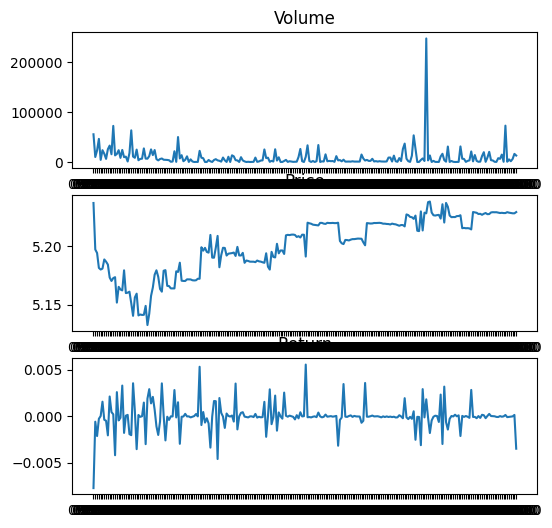

In [142]:
plotfigs("20220602")

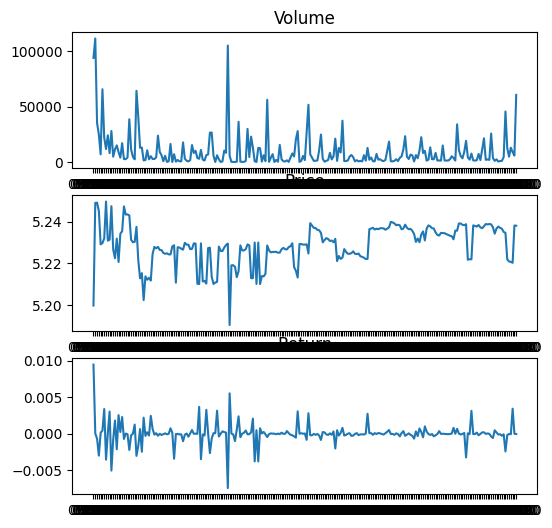

In [143]:
plotfigs("20220606")